In [2]:
import os
import sys
os.chdir('/home/csy/work/3D/PharDiff')
sys.path.append("/home/csy/work/3D/PharDiff/utils")
sys.path.append("/home/csy/work/3D/PharDiff")
import argparse
import multiprocessing as mp
import pickle
import shutil
from functools import partial
from tqdm.auto import tqdm
from utils.data import PDBProtein, parse_sdf_file
from mol_tree import *
import rdkit
import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem
from openbabel import pybel
from openbabel import openbabel as ob
import subprocess
import os
import numpy as np
import shutil
from plip.structure.preparation import PDBComplex
import traceback
import utils.misc as misc
import utils.transforms as trans
from torch_geometric.transforms import Compose
from models.diffusion import PharDiff, log_sample_categorical
from scripts.sample_diffusion import sample_diffusion_ligand
#from pl_data import ProteinLigandData, torchify_dict

In [3]:
def sdf2pdb(sdf_path, pocket_path):
    output_path = sdf_path.replace('.sdf', '.pdb')
    run_line = f'obabel -isdf {sdf_path} -opdb -O {output_path}'
    result = subprocess.run(run_line.split(), capture_output=True, check=True, universal_newlines=True)
    print(result)
    complex_path = pocket_path.replace('.pdb', 'complex.pdb')
    shutil.copy(pocket_path, complex_path)
    
    comp = open(complex_path, 'a')
    comp.write("TER\n")
    
    lig_pdb = open(output_path)
    lines = lig_pdb.readlines()
    for line in lines:
        if line[0:6] == 'HETATM' or line[0:6] == 'CONECT':
            comp.write(line)
    comp.write("END")
    lig_pdb.close()        
    comp.close()
    return complex_path

def load_item(sdf_path, pdb_path):

    with open(pdb_path, 'r') as f:
        pdb_block = f.read()
    with open(sdf_path, 'r') as f:
        sdf_block = f.read()
    return pdb_block, sdf_block

def process_item(sdf_path, pdb_path, pocket_path):
    pdb_block, sdf_block = load_item(sdf_path, pdb_path)
    protein = PDBProtein(pdb_block)
    # ligand = parse_sdf_block(sdf_block)
    ligand = parse_sdf_file(sdf_path)

    pdb_block_pocket = protein.residues_to_pdb_block(
        protein.query_residues_ligand(ligand, 10)
    )    
    pocket_path = pocket_path + pdb_path.split('/')[-1].replace('.pdb', '_pocket.pdb')
    with open(pocket_path, 'w') as f:
        f.write(pdb_block_pocket)
        
    return pocket_path
        
    

조건
- pdb id에 해당하는 directory가 있어야 함 
- 해당 폴더 안에는 protein으로만 구성되어 있는 .pdb파일(직접 정제) 
- ligand에 해당하는 .sdf파일이 있어야 함. 

In [4]:
sdf_path = '/home/csy/work/3D/PharDiff/scripts/pdgfr/1h00_B_FAP.sdf'
pdb_path = '/home/csy/work/3D/PharDiff/scripts/pdgfr/1h00.pdb'
pocket_path = '/home/csy/work/3D/PharDiff/scripts/pdgfr/'
pocket_path = process_item(sdf_path, pdb_path, pocket_path)
complex_path = sdf2pdb(sdf_path, pocket_path)

CompletedProcess(args=['obabel', '-isdf', '/home/csy/work/3D/PharDiff/scripts/pdgfr/1h00_B_FAP.sdf', '-opdb', '-O', '/home/csy/work/3D/PharDiff/scripts/pdgfr/1h00_B_FAP.pdb'], returncode=0, stdout='', stderr='1 molecule converted\n')


In [6]:
def extract_name(classname):
    return classname.split('.')[-1].split("'")[0]  
 
def parse_interaction(inter, inter_list, mol):
    
    if (extract_name(str(inter.__class__)) == 'hydroph_interaction') == True:
        inter_dict = inter._asdict()
        inter_dict["interaction"] = extract_name(str(inter.__class__))
        inter_dict["sdf_idx"] = inter.ligatom_orig_idx - 1 - min(mol.ligands[0].can_to_pdb.values())
        inter_list.append(inter_dict)  
            
    if extract_name(str(inter.__class__)) == 'hbond':
        inter_dict = inter._asdict()
        inter_dict["interaction"] = extract_name(str(inter.__class__))
        if inter.d_orig_idx > min(mol.ligands[0].can_to_pdb.values()):
            inter_dict["sdf_idx"] = inter.d_orig_idx -1 - min(mol.ligands[0].can_to_pdb.values())
        else:
            inter_dict["sdf_idx"] = inter.a_orig_idx -1 - min(mol.ligands[0].can_to_pdb.values())    
        inter_list.append(inter_dict)   
        
    if extract_name(str(inter.__class__)) == 'pistack':
        inter_dict = inter._asdict()
        inter_dict["interaction"] = extract_name(str(inter.__class__))
        inter_dict["sdf_idx"] = [idx - 1 - min(mol.ligands[0].can_to_pdb.values()) for idx in inter_dict['ligandring'].atoms_orig_idx]
        inter_list.append(inter_dict)  
        
    if extract_name(str(inter.__class__)) == 'halogenbond':
        inter_dict = inter._asdict()
        inter_dict["interaction"] = extract_name(str(inter.__class__))
        inter_dict["sdf_idx"] = inter.don.x_orig_idx -1 - min(mol.ligands[0].can_to_pdb.values())
        inter_list.append(inter_dict)       
        
    if extract_name(str(inter.__class__)) == 'pication':
        inter_dict = inter._asdict()
        inter_dict["interaction"] = extract_name(str(inter.__class__))        
    
        # charge쪽이 ligand
        if min(inter.charge.atoms_orig_idx) > min(mol.ligands[0].can_to_pdb.values()):
            inter_dict["sdf_idx"] = [idx -1 - min(mol.ligands[0].can_to_pdb.values()) for idx in inter_dict['charge'].atoms_orig_idx]
        
        # ring쪽이 ligand 
        else:
            inter_dict["sdf_idx"] = [idx -1 - min(mol.ligands[0].can_to_pdb.values()) for idx in inter_dict['ring'].atoms_orig_idx]
        inter_list.append(inter_dict)  
    
    return inter_list  
    
def get_interaction(pdb, sdf_path):
    mol = PDBComplex()
    mol.load_pdb(pdb)
    mol.analyze() 

    longnames = [x.longname for x in mol.ligands]
    bsids = [":".join([x.hetid, x.chain, str(x.position)]) for x in mol.ligands]
    indices = [j for j,x in enumerate(longnames) if x == 'ISK']        
    
    inter_list = [] 
    for bs in bsids:
        interactions = mol.interaction_sets[bs]
        for inter in interactions.all_itypes:
            inter_list = parse_interaction(inter, inter_list, mol)
            
    frag_vocab_dir = '/home/csy/work/3D/targetdiff_phar/datasets/frag_vocab.pickle' 
    with open(frag_vocab_dir, 'rb') as fr:
        Frag_vocab = pickle.load(fr)  
    vocab_idx_dic = dict(zip(list(Frag_vocab.keys()), np.arange(len(list(Frag_vocab.keys())))))         
    vocab_dir = '/home/csy/work/3D/targetdiff_phar/datasets/vocab.txt'
    with open(vocab_dir, 'r') as f:
        vocab = [x.strip() for x in f.readlines()]    
    reference_vocab = np.load('/home/csy/work/3D/FLAG/utils/reference.npy', allow_pickle=True).item()  
    vocab = Vocab(vocab)           
    #temp = pdb.split('/')
    #temp_dir = os.path.join('/'.join(temp[:-2]), temp[-1].replace("complex_", "").replace(".pdb", ".sdf"))
    #crossdock_dir_sdf = temp_dir.replace('complex', 'crossdocked_v1.1_rmsd1.0_pocket10')
    suppl = Chem.SDMolSupplier(sdf_path)
    mol_list = [x for x in suppl if x is not None]  
    for i, mol in enumerate(mol_list):
        tree_list = []
        jt = MolTree(mol, reference_vocab)
        tree_list.append(jt)  
        pairbynode_smi = []
        
        
        preprocessed_inter_list = []
        for inter in inter_list:
            interbynode=[]
            for node in jt.nodes:                
                if (inter['interaction'] == 'hydroph_interaction' or 'halogenbond' or 'hbond'):
                    if (inter["sdf_idx"] in node.clique) == True:
                        interbynode.append(node.clique)                           
                if inter['interaction'] == 'pistack':
                    if (sorted(inter["sdf_idx"]) == sorted(node.clique)) == True:
                        interbynode.append(node.clique)                            
                if inter['interaction'] == 'pication':
                    if len(inter["sdf_idx"]) > 1:
                        if (sorted(inter["sdf_idx"]) == sorted(node.clique)) == True:
                            interbynode.append(node.clique)                 
                    else:
                        if (inter["sdf_idx"][0] in node.clique) == True:
                            interbynode.append(node.clique)  
            
            try:

                if not len(interbynode) == 0: 
                    a = Chem.MolFromSmiles(Chem.MolFragmentToSmiles(jt.mol, sum(interbynode, []), kekuleSmiles=True))
                    smi = Chem.MolFragmentToSmiles(jt.mol, sum(interbynode, []), kekuleSmiles=True)

                    inter['Fragment_smi'] = smi
                    inter['Fragment_idx'] = vocab_idx_dic[smi]
                    inter['Fragment_node'] = list(set(sorted(sum(interbynode, [])))) 
                    if (inter['interaction'] == 'hydroph_interaction'):
                        inter['interaction_onehot'] = [1,0,0,0,0]
                        extract_inter = {key: value for key, value in inter.items() if (key == 'restype') 
                                                                                            or (key == 'resnr')
                                                                                            or (key == 'interaction')
                                                                                            or (key == 'sdf_idx')
                                                                                            or (key == 'Fragment_smi')
                                                                                            or (key == 'Fragment_idx')
                                                                                            or (key == 'Fragment_node')
                                                                                            or (key == 'interaction_onehot')}                            
                    if (inter['interaction'] == 'halogenbond'):
                        inter['interaction_onehot'] = [0,1,0,0,0]
                        extract_inter = {key: value for key, value in inter.items() if (key == 'restype') 
                                                                                            or (key == 'resnr')
                                                                                            or (key == 'interaction')
                                                                                            or (key == 'sdf_idx')
                                                                                            or (key == 'Fragment_smi')
                                                                                            or (key == 'Fragment_idx')
                                                                                            or (key == 'Fragment_node')
                                                                                            or (key == 'interaction_onehot')}   
                    if (inter['interaction'] == 'hbond'):
                        inter['interaction_onehot'] = [0,0,1,0,0]
                        extract_inter = {key: value for key, value in inter.items() if (key == 'restype') 
                                                                                            or (key == 'resnr')
                                                                                            or (key == 'interaction')
                                                                                            or (key == 'sdf_idx')
                                                                                            or (key == 'Fragment_smi')
                                                                                            or (key == 'Fragment_idx')
                                                                                            or (key == 'Fragment_node')
                                                                                            or (key == 'interaction_onehot')} 
                        
                    if (inter['interaction'] == 'pistack'):
                        inter['interaction_onehot'] = [0,0,0,1,0]
                        extract_inter = {key: value for key, value in inter.items() if (key == 'restype') 
                                                                                            or (key == 'resnr')
                                                                                            or (key == 'interaction')
                                                                                            or (key == 'sdf_idx')
                                                                                            or (key == 'Fragment_smi')
                                                                                            or (key == 'Fragment_idx')
                                                                                            or (key == 'Fragment_node')
                                                                                            or (key == 'interaction_onehot')} 
                                                    
                    if (inter['interaction'] == 'pication'):
                        inter['interaction_onehot'] = [1,0,0,0,1]  
                        extract_inter = {key: value for key, value in inter.items() if (key == 'restype') 
                                                                                            or (key == 'resnr')
                                                                                            or (key == 'interaction')
                                                                                            or (key == 'sdf_idx')
                                                                                            or (key == 'Fragment_smi')
                                                                                            or (key == 'Fragment_idx')
                                                                                            or (key == 'Fragment_node')
                                                                                            or (key == 'interaction_onehot')} 
                                            
                    preprocessed_inter_list.append(extract_inter)    
            except Exception as e:
                print(e)
                print("ERROR")
                err_msg = traceback.format_exc()
                print(err_msg)
        if len(preprocessed_inter_list) == 0:
            raise Exception("No interaction")

    return preprocessed_inter_list

In [7]:
import torch
import torch_scatter
import numpy as np
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
class ProteinLigandData(Data):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    @staticmethod
    def from_protein_ligand_dicts(protein_dict=None, ligand_dict=None, residue_dict=None, inter_dict=None, **kwargs):
        instance = ProteinLigandData(**kwargs)

        if protein_dict is not None:
            for key, item in protein_dict.items():
                instance['protein_' + key] = item

        if ligand_dict is not None:
            for key, item in ligand_dict.items():
                instance['ligand_' + key] = item
                
        if residue_dict is not None:
            for key, item in residue_dict.items():
                instance[key] = item
                
        if inter_dict is not None:
            for key, item in inter_dict.items():
                instance[key] = item
        
        instance['ligand_nbh_list'] = {i.item(): [j.item() for k, j in enumerate(instance.ligand_bond_index[1])
                                                  if instance.ligand_bond_index[0, k].item() == i]
                                       for i in instance.ligand_bond_index[0]}
        
        """
        Here it for "residue_pos"
        """
        instance['residue_pos'] = torch.stack([instance['pos_CA'], 
                                               instance['pos_C'], 
                                               instance['pos_N'], 
                                               instance['pos_O']], dim=1)
        
        
        return instance

    def __inc__(self, key, value, *args, **kwargs):
        if key == 'ligand_bond_index':
            return self['ligand_element'].size(0)
        else:
            return super().__inc__(key, value)
def torchify_dict(data):
    output = {}
    for k, v in data.items():
        if isinstance(v, np.ndarray):
            output[k] = torch.from_numpy(v)
        else:
            output[k] = v
    return output

In [8]:
interactions = get_interaction(complex_path, sdf_path)
pdb_block, sdf_block = load_item(sdf_path, pocket_path)
pocket_dict = PDBProtein(pdb_block).to_dict_atom()
residue_dict = PDBProtein(pdb_block).to_dict_residue()
ligand_dict = parse_sdf_file(sdf_path)
interactions_dict = {"IntramolInteraction":interactions}
data = ProteinLigandData.from_protein_ligand_dicts(
    protein_dict=torchify_dict(pocket_dict),
    ligand_dict=torchify_dict(ligand_dict),
    residue_dict=torchify_dict(residue_dict),
    inter_dict=torchify_dict(interactions_dict),
)
data.protein_filename = pdb_path
data.ligand_filename = sdf_path
#data = data.to_dict()

In [20]:
config_path = '/home/csy/work/3D/PharDiff/configs/sampling.yml'
device = 'cuda:0'
sample_size = 10
config = misc.load_config(config_path)
misc.seed_all(config.sample.seed)
ckpt = torch.load(config.model.checkpoint, map_location=device)
protein_featurizer = trans.FeaturizeProteinAtom()
ligand_atom_mode = ckpt['config'].data.transform.ligand_atom_mode
ligand_featurizer = trans.FeaturizeLigandAtom(ligand_atom_mode)
transform = Compose([
    protein_featurizer,
    ligand_featurizer,
    trans.FeaturizeLigandBond(),
])
model = PharDiff(
    ckpt['config'].model,
    protein_atom_feature_dim=protein_featurizer.feature_dim,
    ligand_atom_feature_dim=ligand_featurizer.feature_dim
).to(device)
model.load_state_dict(ckpt['model'])
data = transform(data)

all_pred_pos, all_pred_v, pred_pos_traj, pred_v_traj, pred_v0_traj, pred_vt_traj, time_list = sample_diffusion_ligand(
    model, data, config.sample.num_samples,
    batch_size=sample_size, device=device,
    num_steps=config.sample.num_steps,
    pos_only=config.sample.pos_only,
    center_pos_mode=config.sample.center_pos_mode,
    sample_num_atoms=config.sample.sample_num_atoms
)

  0%|          | 0/1 [00:00<?, ?it/s]

RuntimeError: The size of tensor a (300) must match the size of tensor b (295) at non-singleton dimension 0

In [15]:
result = {
    'data': data,
    'pred_ligand_pos': all_pred_pos,
    'pred_ligand_v': all_pred_v,
    'pred_ligand_pos_traj': pred_pos_traj,
    'pred_ligand_v_traj': pred_v_traj
}

In [16]:
result_path = sdf_path.replace('.sdf', '_result.pickle')
with open(result_path,'wb') as fw:
    pickle.dump(result, fw)

In [12]:
with open(result_path, 'rb') as fr:
    user_loaded = pickle.load(fr)
    
user_loaded

{'data': ProteinLigandData(
   protein_element=[404],
   protein_molecule_name='pocket',
   protein_pos=[404, 3],
   protein_is_backbone=[404],
   protein_atom_name=[404],
   protein_atom_to_aa_type=[404],
   ligand_smiles='CN(C)C[C@H](O)COc1ccc(Nc2cc(Nc3c(F)cccc3F)ncn2)cc1',
   ligand_element=[30],
   ligand_pos=[30, 3],
   ligand_bond_index=[2, 64],
   ligand_bond_type=[64],
   ligand_center_of_mass=[3],
   ligand_atom_feature=[30, 8],
   ligand_hybridization=[30],
   amino_acid=[50],
   center_of_mass=[50, 3],
   pos_CA=[50, 3],
   pos_C=[50, 3],
   pos_N=[50, 3],
   pos_O=[50, 3],
   IntramolInteraction=[10],
   ligand_nbh_list={
     0=[2],
     1=[2],
     2=[3],
     3=[2],
     4=[3],
     5=[3],
     6=[2],
     7=[2],
     8=[3],
     9=[2],
     10=[2],
     11=[2],
     12=[2],
     13=[2],
     14=[2],
     15=[2],
     16=[2],
     17=[2],
     18=[3],
     19=[3],
     20=[2],
     21=[3],
     22=[1],
     23=[1],
     24=[3],
     25=[2],
     26=[3],
     27=[1],
    

In [10]:
result_path = sdf_path.replace('.sdf', '_result.pt')
torch.save(result, result_path)

In [11]:
import argparse
import os, sys
sys.path.append("/home/csy/work/3D/PharDiff")
import numpy as np
from rdkit import Chem
from rdkit import RDLogger
import torch
from tqdm.auto import tqdm
from glob import glob
from collections import Counter

from utils.evaluation import eval_atom_type, scoring_func, analyze, eval_bond_length
from utils import misc, reconstruct, transforms
from utils.evaluation.docking_qvina import QVinaDockingTask
from utils.evaluation.docking_vina import VinaDockingTask

eval_step = -1
r = torch.load('/home/csy/work/3D/PharDiff/scripts/pdgfr/1h00_B_FAP_result.pt')
all_pred_ligand_pos = r['pred_ligand_pos_traj']  # [num_samples, num_steps, num_atoms, 3]
all_pred_ligand_v = r['pred_ligand_v_traj']
num_samples = len(all_pred_ligand_pos) 
num_samples = 0
all_mol_stable, all_atom_stable, all_n_atom = 0, 0, 0
n_recon_success, n_eval_success, n_complete = 0, 0, 0
results = []
all_pair_dist, all_bond_dist = [], []
all_atom_types = Counter()
success_pair_dist, success_atom_types = [], Counter()
cnt = 0
Total = 0
invalid = 0
valid = 0
verbose=True
atom_enc_mode = 'add_aromatic'
docking_mode = 'vina_score'
for sample_idx, (pred_pos, pred_v) in enumerate(zip(all_pred_ligand_pos, all_pred_ligand_v)):
    pred_pos, pred_v = pred_pos[eval_step], pred_v[eval_step]
    #print(pred_pos)
    # stability check
    pred_atom_type = transforms.get_atomic_number_from_index(pred_v, mode=atom_enc_mode)

    all_atom_types += Counter(pred_atom_type)

    r_stable = analyze.check_stability(pred_pos, pred_atom_type)
    all_mol_stable += r_stable[0]
    all_atom_stable += r_stable[1]
    all_n_atom += r_stable[2]

    pair_dist = eval_bond_length.pair_distance_from_pos_v(pred_pos, pred_atom_type)
    all_pair_dist += pair_dist
    try:
        pred_aromatic = transforms.is_aromatic_from_index(pred_v, mode=atom_enc_mode)
        mol = reconstruct.reconstruct_from_generated(pred_pos, pred_atom_type, pred_aromatic)
        smiles = Chem.MolToSmiles(mol)
    except:
        continue
    n_recon_success += 1
    if '.' in smiles:
        #print("Separation error.")
        continue
    try:
        Chem.SanitizeMol(mol)
        valid += 1 
    except:
        #print("Valid error.")
        invalid += 1
        continue            
    n_complete += 1
    try:
        chem_results = scoring_func.get_chem(mol)
        Total += 1
    except:
        cnt += 1
        Total += 1
        print("Valence error(Count of Explicit valence for atom) : ", cnt,"/",Total)
        continue
    #try:
        #chem_results = scoring_func.get_chem(mol)
    if docking_mode == 'qvina':
        vina_task = QVinaDockingTask.from_generated_mol(
            mol, r['data'].ligand_filename, protein_root=args.protein_root)
        vina_results = vina_task.run_sync()
    elif docking_mode in ['vina_score', 'vina_dock']:
        vina_task = VinaDockingTask.from_generated_mol(
            mol, r['data'].ligand_filename, 
            protein_root ='/home/csy/work/3D/PharDiff/scripts/pdgfr') # , protein_root=args.protein_root
        score_only_results = vina_task.run(mode='score_only', exhaustiveness=16)
        minimize_results = vina_task.run(mode='minimize', exhaustiveness=16)
        vina_results = {
            'score_only': score_only_results,
            'minimize': minimize_results
        }
        if docking_mode == 'vina_dock':
            docking_results = vina_task.run(mode='dock', exhaustiveness=16)
            vina_results['dock'] = docking_results
    else:
        vina_results = None

    n_eval_success += 1
    # except:
    #     print("docking error")
    #     continue
    
    bond_dist = eval_bond_length.bond_distance_from_mol(mol)
    success_pair_dist += pair_dist
    success_atom_types += Counter(pred_atom_type)
    
    results.append({
        'mol': mol,
        'smiles': smiles,
        'ligand_filename': r['data'].ligand_filename,
        'pred_pos': pred_pos,
        'pred_v': pred_v,
        'chem_results': chem_results,
        'vina': vina_results
    })


: 

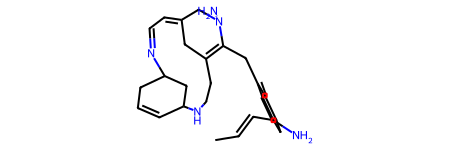

In [52]:
mol